# Regression

In [1]:
import geopandas as gpd

blocks_gdf = gpd.read_parquet('./blocks.parquet')

Fix columns almost equal 1

In [2]:
from blocksnet.enums import LandUse

land_use_columns = [lu.value for lu in LandUse]
blocks_gdf[land_use_columns] = blocks_gdf[land_use_columns].clip(upper=1)

Filter only viable rows

In [3]:
blocks_gdf = blocks_gdf[(blocks_gdf[['fsi', 'gsi']] > 0).all(axis=1)]
blocks_gdf = blocks_gdf[(blocks_gdf[['gsi', 'mxi']] <= 1).all(axis=1)]

Initialize graph

In [4]:
from blocksnet.relations import generate_adjacency_graph

adjacency_graph = generate_adjacency_graph(blocks_gdf, 10)

2025-04-15 16:22:17.177 | INFO     | blocksnet.relations.adjacency.core:_generate_adjacency_nodes:10 - Generating nodes
2025-04-15 16:22:17.182 | INFO     | blocksnet.relations.adjacency.core:_generate_adjacency_edges:15 - Generating edges
2025-04-15 16:22:19.058 | SUCCESS  | blocksnet.relations.adjacency.core:generate_adjacency_graph:38 - Adjacency graph successfully generated: 5350 nodes, 15279 edges


## Density

In [5]:
from blocksnet.machine_learning.regression import DensityRegressor

dr = DensityRegressor()

### Train

In [33]:
data = dr.get_train_data(blocks_gdf, adjacency_graph, fit_scaler=True, test=0.2)

2025-04-15 15:49:33.992 | INFO     | blocksnet.preprocessing.feature_engineering.core:_calculate_usual_features:34 - Calculating usual features
2025-04-15 15:49:34.107 | INFO     | blocksnet.machine_learning.regression.density.core:_features_from_geometries:46 - Fitting the scaler


In [34]:
train_losses, test_losses = dr.train(data, epochs=250, learning_rate=3e-4, weight_decay=0, delta=0.5)

Train loss: 0.02410 | Test loss: 0.03729: 100%|██████████| 250/250 [00:22<00:00, 11.00it/s]


<Axes: >

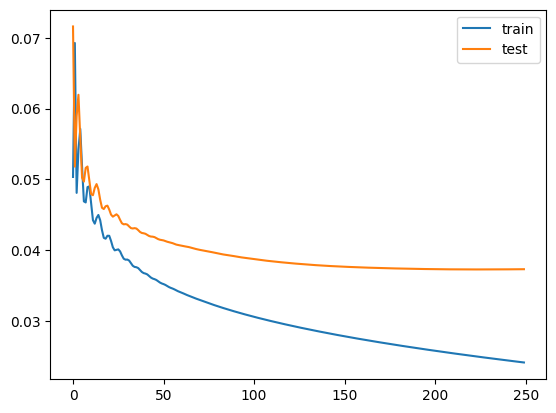

In [37]:
import pandas as pd

pd.DataFrame.from_dict({
  'train': train_losses,
  'test': test_losses,
}).plot()

### Test

In [38]:
dr.test(data, delta=0.5)

0.03729007765650749

### Evaluate

In [6]:
result_df = dr.evaluate(blocks_gdf, adjacency_graph)

2025-04-15 16:22:29.517 | INFO     | blocksnet.preprocessing.feature_engineering.core:_calculate_usual_features:34 - Calculating usual features


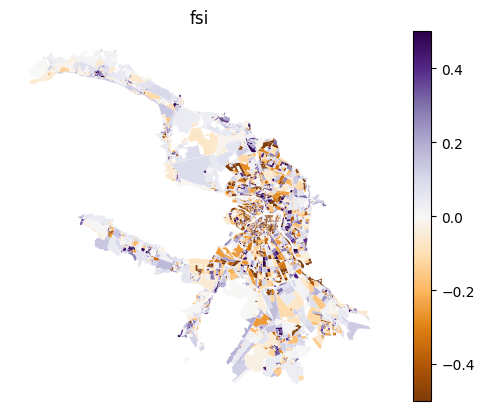

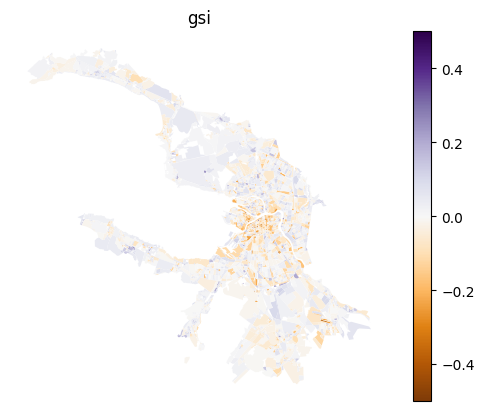

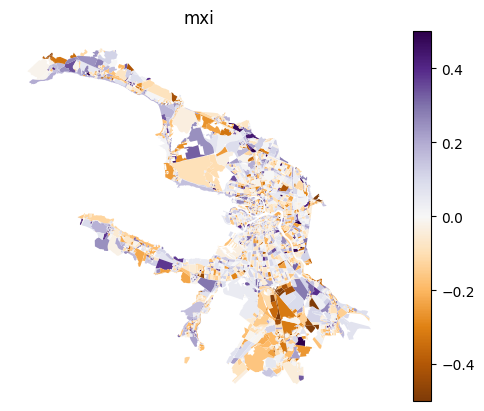

In [7]:
df = result_df.copy()
for column in df.columns:
  df[column] -= blocks_gdf[column]
  ax = blocks_gdf[['geometry']].join(df).plot(column, cmap='PuOr', legend=True, vmin=-0.5, vmax=0.5)
  ax.set_title(column)
  ax.set_axis_off()

### Save model and scaler

In [8]:
dr.save_model('model.pt')
dr.save_scaler('scaler.pkl')